## Does the inclusion of cryptocurrency-based indicies extend the MV frontier of a well diversified equity investor?

<span style="color:red"> **ADD ABSTRACT HERE**</span>.


Please make sure you have run the [src/data/make_dataset.py](../src/data/make_dataset.py) in order to reproduce our results. Also note that you need to be in the */src/data* folder to be able to run the script. To use own data, please see instructions in [README](../README.md#data-grabbing). 

# Loading libraries and importing data

In [1]:
import numpy as np
import pandas as pd
import scipy 
import scipy.optimize as opt
import matplotlib.pyplot as plt
import textwrap # Do we really need this? maybe just make a sub title?
import seaborn as sns

TICKERS_CRYPTO = ["BTC-USD", "ETH-USD", "XRP-USD"] # make this more elegant with an import from the config file (maybe make it JSON, to avoid the annoying import porblem)

# Paramaters
rf = 0.0215 # Risk-free rate 
periods_per_year = 260 # Number of trading days per year

In [2]:
ind_crypto = pd.read_csv('../data/dataset.csv', parse_dates=True, index_col='Date')

# defining lists of assets used later in optmizer:
industry_and_crypto = ind_crypto.columns.values.tolist()
industry = [item for item in industry_and_crypto if item not in TICKERS_CRYPTO]

# Summary statistics

In [3]:
ind_crypto.describe()

,NoDur,Durbl,Manuf,Enrgy,Chems,BusEq,Telcm,Utils,Shops,Hlth,Money,Other,BTC-USD,ETH-USD,XRP-USD
count,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000,1480.000000
mean,0.000278,0.000409,0.000533,0.000823,0.000483,0.000615,0.000120,0.000342,0.000590,0.000210,0.000406,0.000474,0.001941,0.002846,0.003418
std,0.013419,0.018021,0.016582,0.029664,0.016406,0.016811,0.016447,0.013238,0.016897,0.018203,0.015313,0.015111,0.045450,0.058645,0.079164
min,-0.107600,-0.119700,-0.119800,-0.262000,-0.111100,-0.116100,-0.116200,-0.117400,-0.137000,-0.122000,-0.127200,-0.139200,-0.371695,-0.423472,-0.423340
25%,-0.006500,-0.009300,-0.008100,-0.014625,-0.008700,-0.007700,-0.008600,-0.005225,-0.008300,-0.010025,-0.006400,-0.006300,-0.017276,-0.023467,-0.026419
50%,0.000500,0.000200,0.000700,0.000150,0.000800,0.001350,0.000200,0.000700,0.000500,0.000950,0.000200,0.000700,0.000942,0.000470,-0.000737
75%,0.006900,0.009900,0.009200,0.016050,0.009700,0.009700,0.008825,0.006400,0.008900,0.010425,0.007100,0.007500,0.021195,0.029656,0.025058
max,0.088100,0.107500,0.101100,0.226700,0.076900,0.095100,0.086200,0.125400,0.124600,0.086800,0.098200,0.107300,0.252472,0.409905,0.871502


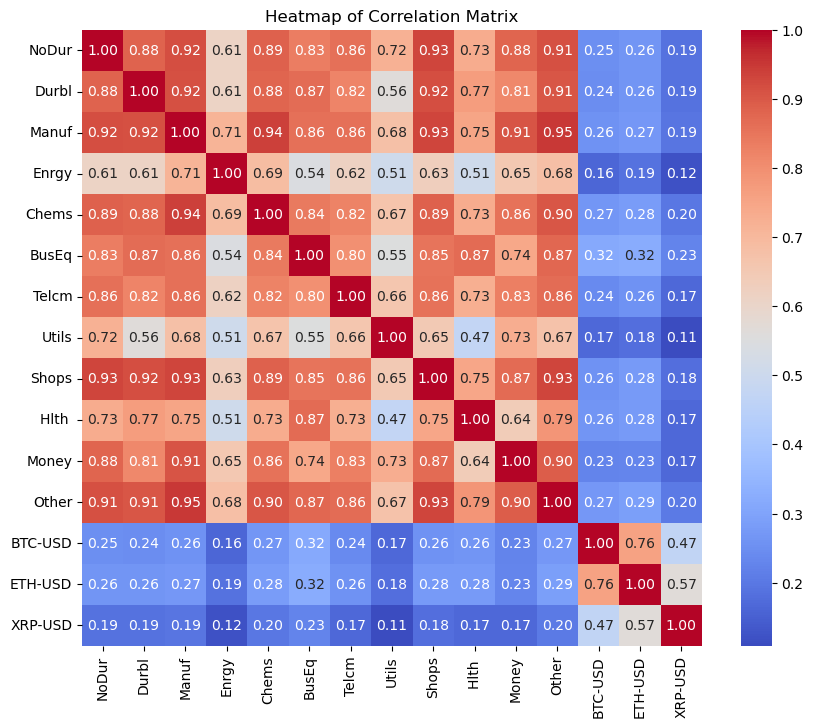

In [4]:
# Plotting correlation matrix as heatmap.
plt.figure(figsize=(10, 8))

sns.heatmap(ind_crypto.corr(), annot=True, fmt=".2f", cmap='coolwarm')

plt.title("Heatmap of Correlation Matrix")
plt.savefig("../Reports/figures/heatmap_correlation.png")
plt.show()

# Defining functions needed to compute the efficient frontier

### Defining functions needed to compute the efficient frontier:


The `annualize_rets` function is designed to annualize a set of return series by calculating the compounded growth of returns and then converting it to an annualized rate, adjusting for the number of return periods in a year. It takes two parameters:

- `r`: The input returns as a pandas Series or DataFrame.
- `periods_per_year`: The number of return periods in a year (e.g., 252 for daily returns, 12 for monthly returns).

$$ \text{Annualized Return} = \left( \prod_{i=1}^{n} (1 + r_i) \right)^{\frac{\text{periods\_per\_year}}{n}} - 1 $$


In [5]:
def annualize_rets(r, periods_per_year):
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods)-1

The `annualize_vol` function is annualizes the volatility of a set of returns, it takes the two paramaters described above.

$ \text{Annualized Volatility} = \text{Standard Deviation of Returns} \times \sqrt{\text{Number of Periods per Year}} $

In [6]:
def annualize_vol(r, periods_per_year):
    return r.std()*(periods_per_year**0.5)

The `sharpe_ratio` function computes the annualized sharpe ratio representing the risk-adjusted performance of each of the included portfolios. Additionally it takes the above-defined annual risk-free rate as a paramater and converts it to correspond to each trading day. 

   $ \text{rf\_per\_period} = (1 + \text{riskfree\_rate})^{(1/\text{periods\_per\_year})} - 1 $

   $ \text{Sharpe Ratio} = \frac{\text{ann\_ex\_ret}}{\text{ann\_vol}} $

In [7]:
def sharpe_ratio(r, riskfree_rate, periods_per_year):
    # convert the annual riskfree rate to per period
    rf_per_period = (1+riskfree_rate)**(1/periods_per_year)-1
    excess_ret = r - rf_per_period
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

The `minimize_vol` function takes as inputs the set of expected returns and a corresponding covariance matrix and returns a set of optimized portfolio weights that achieve the target return, by using the `opt.minimize` function which takes as the objective function the `portfolio_vol`. The optimization method chosen is the Sequential Least SQuares Programming (SLSQP) which iteratively solves a bunch of quadratic subproblems until it converges to a solution that satisfies the imposed conditions. The general optimization problem looks like this:

$ \text{Minimize:} \quad f(x)\ $

$ \
\text{Subject to:} \quad g_i(x) = 0 \quad \text{for equality constraints}
\ $

$ \
\quad \quad \quad g_i(x) \geq 0 \quad \text{for inequality constraints}
\ $

The math for the resulting subproblems in each iteration is likely beyond the scope of this assignment

In [8]:
def minimize_vol(target_return, er, cov):
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = opt.minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

The following function:
* generates a set of target returns evenly spaced between the minimum and maximum expected retzrns in the inputed series of expected returns using `np.linspace`,
* for each target return in the above set it calls the `minimize_vol` to find the optimal weights for a portfolio that achieves corresponding target return

In [9]:
def optimal_weights(n_points, er, cov):
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

The portfolio volatility is calculated using the following linear algebra expression:

$ \text{Portfolio Volatility} = \sqrt{ \mathbf{w}^T \cdot \Sigma \cdot \mathbf{w} } $

Where:
- $ \mathbf{w} \ $ is the column vector of weights computed in the function above.
- $ \Sigma $ is the covariance matrix of returns.

In [10]:
def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5

The function below computes the return on a portfolio from inputted weights and returns, both in the form of a numpy array

$ \text{Portfolio Return} = \mathbf{w}^T \cdot \mathbf{r} $

In [11]:
def portfolio_return(weights, returns):
    return weights.T @ returns

Computing the sharpe ratios of all chosen instruments (which are merged inside of the ind_crypto dataframe)

In [12]:
# Load the processed data for analysis, choose the RF rate
industry_SR = sharpe_ratio(ind_crypto, rf, periods_per_year).sort_values()
industry_SR

Telcm     -0.094872
Hlth      -0.033561
XRP-USD    0.110898
NoDur      0.128877
Durbl      0.149893
Enrgy      0.171032
Utils      0.214889
Money      0.223324
Chems      0.270244
Other      0.305880
Manuf      0.316342
BTC-USD    0.321772
ETH-USD    0.325400
Shops      0.365586
BusEq      0.395438
dtype: float64

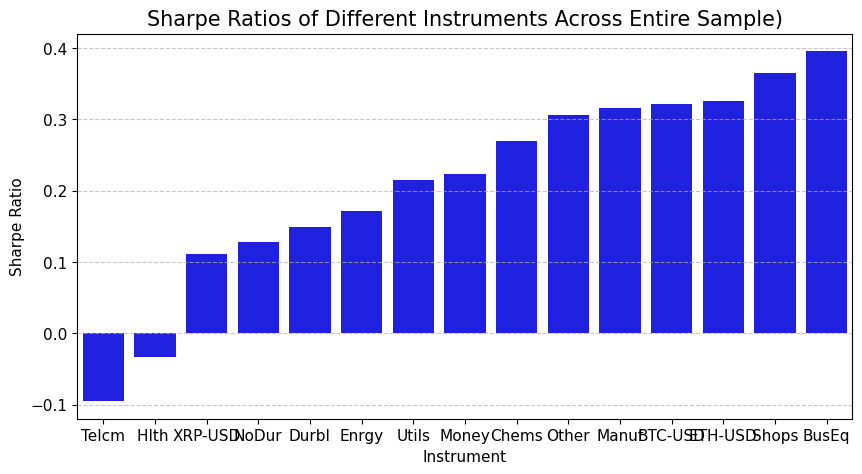

In [13]:
data = {'Sharpe Ratio': industry_SR}
df = pd.DataFrame(data)

# Plotting the temperature plot using seaborn
plt.figure(figsize=(10, 5))  # Adjust the size here
sns.barplot(x=df.index, y='Sharpe Ratio', data=df, color='b')
plt.title('Sharpe Ratios of Different Instruments Across Entire Sample)', fontsize=15)
plt.xlabel('Instrument', fontsize=11)
plt.ylabel('Sharpe Ratio', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.savefig("../Reports/figures/SR_Entire_Sample.png")
plt.show()

Paramaters and plot limits for 3 different market timeframes to facilitate reproducibility. The desired dates corresponding to different timeframes are to be inputed inside of the first cell in src\data\data_grabbing.ipynb.

- Equity bull market
    - Period: 2017-10-31 <--> 2021-12-1
    - 3-y T-bill rate = 1.9 %
    - *ax.set_xlim(left=0.0125, right=0.0155)*
    - *ax.set_ylim(bottom=0.155, top=0.3)*
- High vol equity market with large drawdowns
    - Period: 2021-12-1 <--> 2023-10-31
    - 3-y T-bill rate = 0.95 %
    - *ax.set_xlim(left=0.0075, right=0.025)* 
    - *ax.set_ylim(bottom=0.0, top=0.35)*
- Large sample encapsulating different equity market regimes 
    - Period: 2017-10-31 <--> 2023-10-31
    - 5-y T-bill rate = 2.15 %
    - *ax.set_xlim(left=0.0114, right=0.015)*
    - *ax.set_ylim(bottom=0.04, top=0.12)*

For better interpretability, we advise the reader to adjust the axis limits of plotted graphs in each of the three periods when plotting the frontiers & exporting the .png files which is to be done by inputing the code * inside the plot_ef function below.

Computing efficient froniters

In [14]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies', color='b', marker='o', markersize=4)
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies', color='r', marker='s', markersize=4)
    
    ax.set_xlim(left=0.0114, right=0.015) #Adjust according to the desired timeframe
    ax.set_ylim(bottom=0.04, top=0.12) #Adjust according to the desired timeframe

    # Customize the plot as needed
    title_text = "Efficient Frontier Comparison\nDuring the Entire Available Sample\n(Timeframe: 2017-10-31 - 2023-10-31)"
    plt.title("\n".join(textwrap.wrap(title_text, width=30)), fontsize=15) 
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Returns", fontsize=11)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    #plt.savefig("../reports/figures/TEST-Efficient_Frontier_Comparison_Full_Sample).png")
    #plt.show()
    

Plotting the mean-variance frontiers

/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


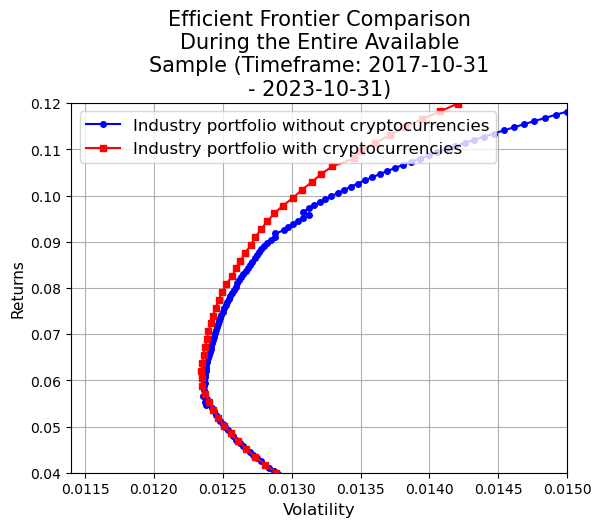

In [15]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()
industry_crypto_combined_plots = plot_ef(201, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto])

plt.savefig("../Reports/figures/Efficient_Frontier_Comparison_Full_Sample.png")
plt.show()

# different time periods

Paramaters and plot limits for 3 different market timeframes to facilitate reproducibility. The desired dates corresponding to different timeframes are to be inputed inside of the first cell in src\data\data_grabbing.ipynb.

- Equity bull market
    - Period: 2017-10-31 <--> 2021-12-1
    - 3-y T-bill rate = 1.9 %
    - *ax.set_xlim(left=0.0125, right=0.0155)*
    - *ax.set_ylim(bottom=0.155, top=0.3)*
- High vol equity market with large drawdowns
    - Period: 2021-12-1 <--> 2023-10-31
    - 3-y T-bill rate = 0.95 %
    - *ax.set_xlim(left=0.0075, right=0.025)* 
    - *ax.set_ylim(bottom=0.0, top=0.35)*
- Large sample encapsulating different equity market regimes 
    - Period: 2017-10-31 <--> 2023-10-31
    - 5-y T-bill rate = 2.15 %
    - *ax.set_xlim(left=0.0114, right=0.015)*
    - *ax.set_ylim(bottom=0.04, top=0.12)*

For better interpretability, we advise the reader to adjust the axis limits of plotted graphs in each of the three periods when plotting the frontiers & exporting the .png files which is to be done by inputing the code * inside the plot_ef function below.

### Adjusting plot formula for bull plot

In [16]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies', color='b', marker='o', markersize=4)
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies', color='r', marker='s', markersize=4)
    
    ax.set_xlim(left=0.0125, right=0.0155)
    ax.set_ylim(bottom=0.155, top=0.3)

    # Customize the plot as needed
    title_text = "Efficient Frontier Comparison\nDuring the Entire Available Sample\n(Timeframe: 2017-10-31 - 2023-10-31)"
    plt.title("\n".join(textwrap.wrap(title_text, width=30)), fontsize=15) 
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Returns", fontsize=11)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    #plt.savefig(f"../reports/figures/TEST-Efficient_Frontier_Comparison_Full_Sample).png")
    #plt.show()
    

/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


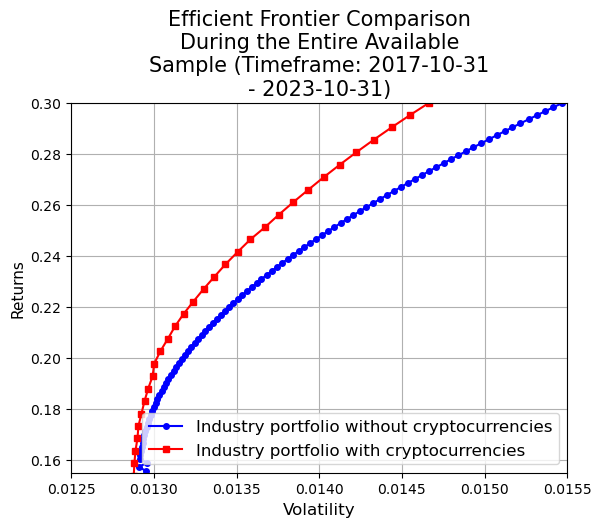

In [17]:
ind_crypto_bull = ind_crypto['2017-10-31' :'2021-12-01']
r = 0.019

er = annualize_rets(ind_crypto_bull, periods_per_year)
cov = ind_crypto_bull.cov()

industry_crypto_combined_plots = plot_ef(201, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto])

plt.savefig("../Reports/figures/Efficient_Frontier_Comparison_Bull.png")

plt.show()

### Adjusting plot formula for high vol plot

In [18]:
def plot_ef(n_points, er, cov, er2, cov2):
    """
    Plots two multi-asset efficient frontiers on the same graph
    """
    # First efficient frontier
    weights = optimal_weights(n_points, er, cov)  # Assuming optimal_weights is implemented
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef1 = pd.DataFrame({
        "Returns": rets,
        "Volatility": vols
    })

    # Second efficient frontier
    weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
    rets2 = [portfolio_return(w, er2) for w in weights2]
    vols2 = [portfolio_vol(w, cov2) for w in weights2]
    ef2 = pd.DataFrame({
        "Returns": rets2,
        "Volatility": vols2
    })

    # Plotting both efficient frontiers on the same graph
    ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies', color='b', marker='o', markersize=4)
    ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies', color='r', marker='s', markersize=4)
    
    #ax.set_xlim(left=0.0075, right=0.025) 
    #ax.set_ylim(bottom=0.0, top=0.35)

    # Customize the plot as needed
    title_text = "Efficient Frontier Comparison\nDuring the Entire Available Sample\n(Timeframe: 2017-10-31 - 2023-10-31)"
    plt.title("\n".join(textwrap.wrap(title_text, width=30)), fontsize=15) 
    plt.xlabel("Volatility", fontsize=12)
    plt.ylabel("Returns", fontsize=11)
    plt.legend(fontsize=12)
    plt.grid(True)
    
    #plt.savefig(f"../reports/figures/TEST-Efficient_Frontier_Comparison_Full_Sample).png")
    #plt.show()
    

/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)
/home/thomas/miniconda3/envs/myenv/lib/python3.11/site-packages/pandas/plotting/_matplotlib/core.py:891: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string ".-" (-> marker='.'). The keyword argument will take precedence.
  return ax.plot(*args, **kwds)


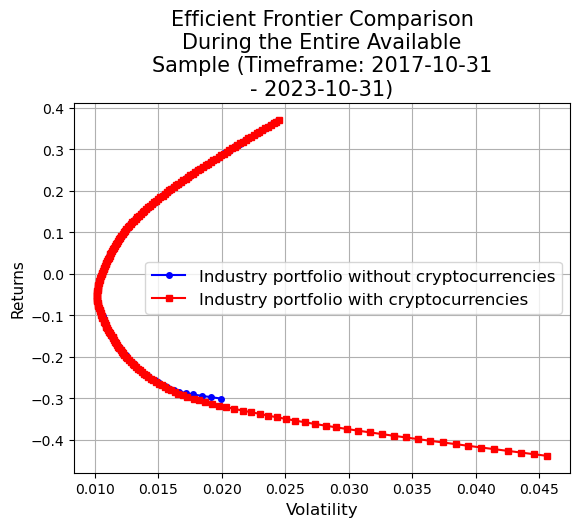

In [19]:
ind_crypto_high_vol = ind_crypto['2021-12-01' :'2023-10-31']
r = 0.0095
er = annualize_rets(ind_crypto_high_vol, periods_per_year)
cov = ind_crypto_high_vol.cov()

industry_crypto_combined_plots = plot_ef(201, er[industry], cov.loc[industry, industry], er[industry_and_crypto], cov.loc[industry_and_crypto, industry_and_crypto]) 


plt.savefig("../Reports/figures/Efficient_Frontier_Comparison_High_Vol.png")
plt.show()

# trying some stuff for widgets

In [275]:
er = annualize_rets(ind_crypto, periods_per_year)
cov = ind_crypto.cov()

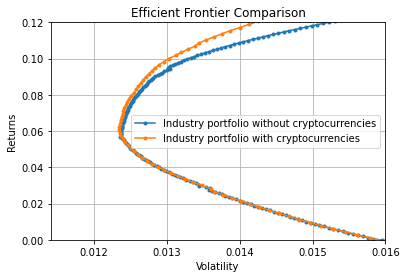

In [95]:
er1 = er[industry]
cov1 = cov.loc[industry, industry]
er2 = er[industry_and_crypto]
cov2 = cov.loc[industry_and_crypto, industry_and_crypto]
n_points = 200

# First efficient frontier
weights1 = optimal_weights(n_points, er1, cov1)  # Assuming optimal_weights is implemented
rets1 = [portfolio_return(w, er1) for w in weights]
vols1 = [portfolio_vol(w, cov1) for w in weights]
ef1 = pd.DataFrame({
        "Returns": rets1,
        "Volatility": vols1
    })

# Second efficient frontier
weights2 = optimal_weights(n_points, er2, cov2)  # Assuming optimal_weights is implemented
rets2 = [portfolio_return(w, er2) for w in weights2]
vols2 = [portfolio_vol(w, cov2) for w in weights2]
ef2 = pd.DataFrame({
    "Returns": rets2,
    "Volatility": vols2
})

# Plotting both efficient frontiers on the same graph
ax = ef1.plot.line(x="Volatility", y="Returns", style='.-', label='Industry portfolio without cryptocurrencies')
ef2.plot.line(x="Volatility", y="Returns", style='.-', ax=ax, label='Industry portfolio with cryptocurrencies')
    
ax.set_xlim(left=0.0114, right=0.016)
ax.set_ylim(bottom=0.0, top=0.12)

# Customize the plot as needed
plt.title("Efficient Frontier Comparison")
plt.xlabel("Volatility")
plt.ylabel("Returns")
plt.legend()
plt.grid(True)
    
plt.savefig("../reports/figures/figure1.png")
plt.show()

In [92]:
ef2

,Returns,Volatility
0,-0.004197,0.016447
1,-0.002488,0.016156
2,-0.000779,0.015984
3,0.000929,0.015788
4,0.002638,0.015615
...,...,...
195,0.329005,0.056454
196,0.330714,0.056989
197,0.332423,0.057532
198,0.334131,0.058084


In [56]:
import pandas as pd
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets

# Example DataFrame with returns
# Replace this with your actual DataFrame
data = {
    'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
    'Portfolio1': [0.02, 0.01, -0.015, 0.03, -0.01],
    'Portfolio2': [0.015, 0.02, -0.01, 0.025, -0.02],
    'Portfolio3': [-0.01, 0.03, -0.02, 0.015, 0.01]
}

df = pd.DataFrame(data)
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# Function to plot scatter plot
def plot_scatter(start_date, end_date):
    selected_data = df.loc[start_date:end_date]
    
    plt.figure(figsize=(10, 6))
    for column in selected_data.columns:
        plt.scatter(selected_data.index, selected_data[column], label=column)

    plt.title('Portfolio Returns Over Time')
    plt.xlabel('Date')
    plt.ylabel('Returns')
    plt.legend()
    plt.show()

# Create widgets for date selection
start_date_widget = widgets.DatePicker(description='Start Date', value=df.index.min())
end_date_widget = widgets.DatePicker(description='End Date', value=df.index.max())

# Create interactive plot
interact(plot_scatter, start_date=start_date_widget, end_date=end_date_widget)


interactive(children=(DatePicker(value=Timestamp('2023-01-01 00:00:00'), description='Start Date'), DatePicker…

<function __main__.plot_scatter(start_date, end_date)>